# Identify significant differences between model and ERA5 AR regime anomalies

* Input: `/glade/work/mkorendy/metisregimes/data.AR.10%.PNA.NDJFM.k5.composite.nc`
* Input: `/glade/work/mkorendy/metisregimes/data.AR.10%.PNA.NDJFM.k5.clustering.nc`

1. Take the difference between the composites (means)

3. Calculate the significance of the differences

4. Plot composite of mean difference with significance in hatching

* Output: `era_vs_metis199.AR.10%.PNA.NDJFM.k5.diff_anoms.png`

## Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.stats import ttest_ind

## Files

In [2]:
path = '/glade/work/mkorendy/metisregimes/'

f_era_comp = path + 'era5.AR.10%.PNA.NDJFM.k5.composite.nc'
f_metis_comp = path + 'metis199.AR.10%.PNA.NDJFM.k5.composite.nc'

f_era_raw = path + 'era5.AR.10%.PNA.NDJFM.k5.clustering.nc'
f_metis_raw = path + 'metis199.AR.10%.PNA.NDJFM.k5.clustering.nc'

f_out = 'era5_vs_metis199.AR.10%.PNA.NDJFM.k5.diff_anoms.png'

## Read in data

In [3]:
# Means
ds_era_comp = xr.open_dataset(f_era_comp)
ds_metis_comp = xr.open_dataset(f_metis_comp)

# Raw data
ds_era_raw = xr.open_dataset(f_era_raw)
ds_metis_raw = xr.open_dataset(f_metis_raw)

## Identify the clusters
Use highest correlation with regimes for metis199 identification

In [4]:
era_regimes = ['Pacific Wavetrain', 'Arctic Low', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
metis_regimes = ['Pacific Trough', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low', 'Alaskan Ridge']

ds_era_comp = ds_era_comp.assign_coords(cluster=era_regimes)
ds_metis_comp = ds_metis_comp.assign_coords(cluster=metis_regimes)

In [5]:
#Identify for raw data by iterating through the clusters, replacing with 

ls_era_raw = []
for clust in ds_era_raw.cluster.values:
    ls_era_raw.append(era_regimes[clust])

ls_metis_raw = []
for clust in ds_metis_raw.cluster.values:
    ls_metis_raw.append(metis_regimes[clust])

In [6]:
ds_era_raw = ds_era_raw.assign_coords(cluster=ls_era_raw)
ds_metis_raw = ds_metis_raw.assign_coords(cluster=ls_metis_raw)

## Take the difference in the composites for each cluster

In [7]:
ds_diff = ds_era_comp - ds_metis_comp

In [8]:
ds_metis_comp.river_anoms

<xarray.DataArray 'river_anoms' (cluster: 5, lat: 22, lon: 53)>
array([[[ 0.000000e+00,  0.000000e+00, ..., -6.148725e-01, -3.907042e-01],
        [-4.356627e-01, -6.961595e-01, ..., -1.534076e+00, -1.534076e+00],
        ...,
        [ 1.601399e-01,  8.283064e+00, ..., -5.061742e-01,  1.092542e+01],
        [-3.266642e+01, -3.271348e+01, ..., -9.893727e+01, -1.062240e+02]],

       [[ 0.000000e+00,  0.000000e+00, ..., -8.682019e-01, -6.000132e-01],
        [ 4.268534e-01,  1.771666e-01, ...,  6.511340e-02,  6.511340e-02],
        ...,
        [-4.152465e+01, -3.323871e+01, ..., -2.801976e+01, -4.136669e+01],
        [ 3.431932e+01,  2.969946e+01, ..., -5.871764e+01, -7.550168e+01]],

       ...,

       [[ 0.000000e+00,  0.000000e+00, ...,  3.526744e-01, -4.564873e-01],
        [-4.292994e-01, -6.268292e-01, ...,  5.865127e-01,  5.865127e-01],
        ...,
        [ 1.265877e+02,  8.665655e+01, ...,  4.649380e+01,  4.204165e+01],
        [ 5.560046e+01,  3.274440e+01, ...,  9.296657e+01,  1.064830e+02]],

       [[ 0.000000e+00,  0.000000e+00, ...,  5.227447e-01,  7.004231e-01],
        [ 6.838650e-01,  5.123217e-01, ...,  8.165737e-01,  8.165737e-01],
        ...,
        [-9.291246e+01, -8.401402e+01, ..., -1.607206e+01, -1.640550e+01],
        [-3.166078e+01, -1.719947e+01, ...,  3.916177e+01,  2.736369e+01]]])
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) <U17 'Pacific Trough' ... 'Alaskan Ridge'

## Significance of the difference

### State the problem
Where is the mean difference different enough to be considered significant (meaning its unlikely it happened by random chance)?

$\mu_x$ = ERA5 Composite ($n_x$ = 8160)

$\mu_y$ = Metis199 Composite ($n_y$ = 204000)

### Define our Null Hypothesis

Null Hypothesis (H0): Differences between the two means is zero

$\mu_x-\mu_y=0$

### Pick a level of significance

In [9]:
p = .1

### Use the stats `ttest_ind` function
Iterate through each cluster's raw data to get the pvalue
Then mask the difference data using the pvalue

In [10]:
ls_mask = []

for k in np.arange(0,5):
    era_clust = ds_era_raw.sel(cluster = era_regimes[k]).drop('time')
    metis_clust = ds_metis_raw.sel(cluster = era_regimes[k])

    tstat, pval = ttest_ind(era_clust.river_anoms,metis_clust.river_anoms,equal_var=False)
    
    mask = ds_diff.river_anoms[k].where(pval < p)
    
    ls_mask.append(mask)

/glade/u/home/mkorendy/miniconda3/envs/wxregimes/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/u/home/mkorendy/miniconda3/envs/wxregimes/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [11]:
da_mask = xr.DataArray(ls_mask, coords={'cluster':ds_diff.cluster,'lat':ds_diff.lat,
                                       'lon':ds_diff.lon}, dims=['cluster','lat','lon'])

## Plot the masked difference

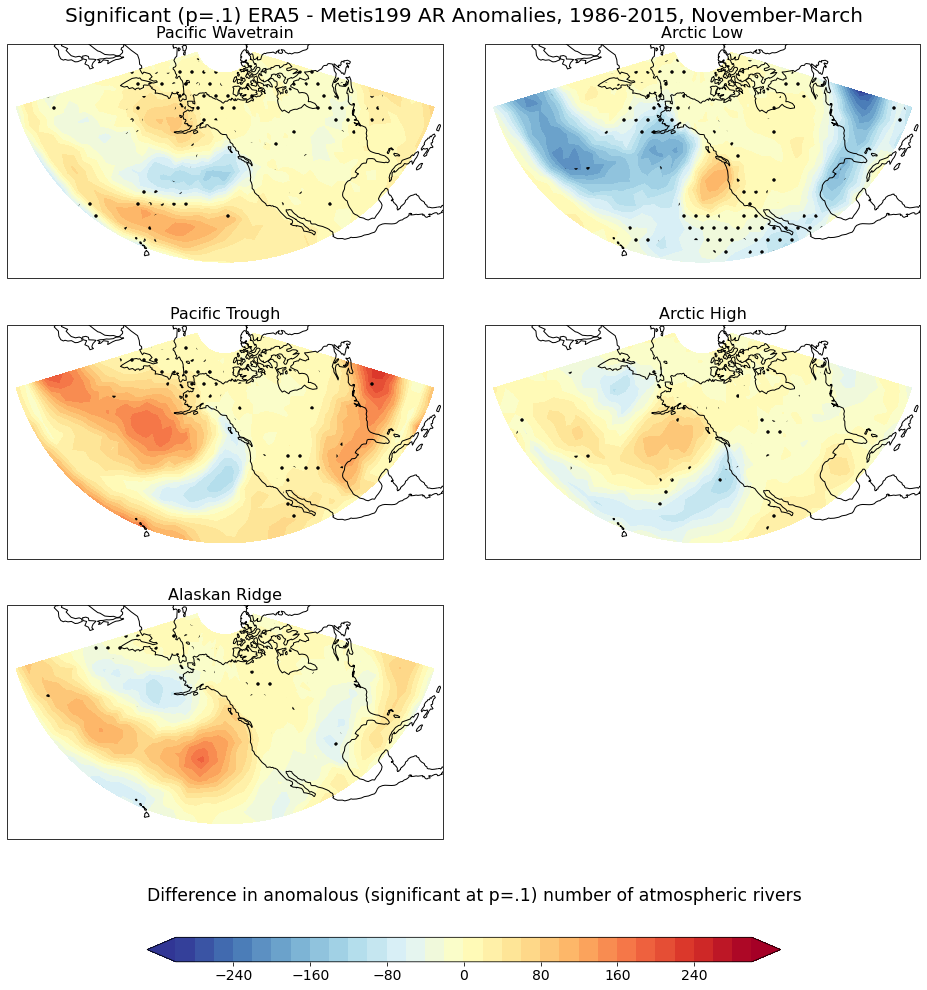

In [15]:
cm = 225
minlon = -70 + cm
maxlon = 80 + cm

clevs = np.arange(-300,320,20)

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
#proj = ccrs.PlateCarree(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
    ax.set_extent((minlon+15,maxlon-25,10,90))
    if (i < 5):
        cs=ax.contourf(ds_diff['lon'],ds_diff['lat'],
                       ds_diff.river_anoms[i] + 1e-100,clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r', extend='both')
        cs2=ax.contourf(ds_diff['lon'],ds_diff['lat'],
                   da_mask[i] + 1e-100,[0,1],colors='None',
                   transform=ccrs.PlateCarree(),hatches=['.',''],extend='both',alpha=0)
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(era_regimes[i],fontdict={'fontsize':16})
        #ax.gridlines()
        ax.coastlines()
fig.delaxes(axs.flatten()[5])

fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.figtext(.3,.25,'Difference in anomalous (significant at p=.1) number of atmospheric rivers',
                    fontsize='xx-large')

plt.suptitle('Significant (p=.1) ERA5 - Metis199 AR Anomalies, 1986-2015, November-March', fontsize=20)
plt.savefig(f_out)